In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

Loading data from: /ess/scratch/scratch1/rachelgordon/simulated_dataset/sample_002_sub2

Successfully loaded data from .npy files:
  - DRO Ground Truth Shape:  (320, 320, 21)
  - Reconstructed Image Shape: (320, 320, 22)
  - Coil Sensitivity Maps Shape: (320, 320, 16)


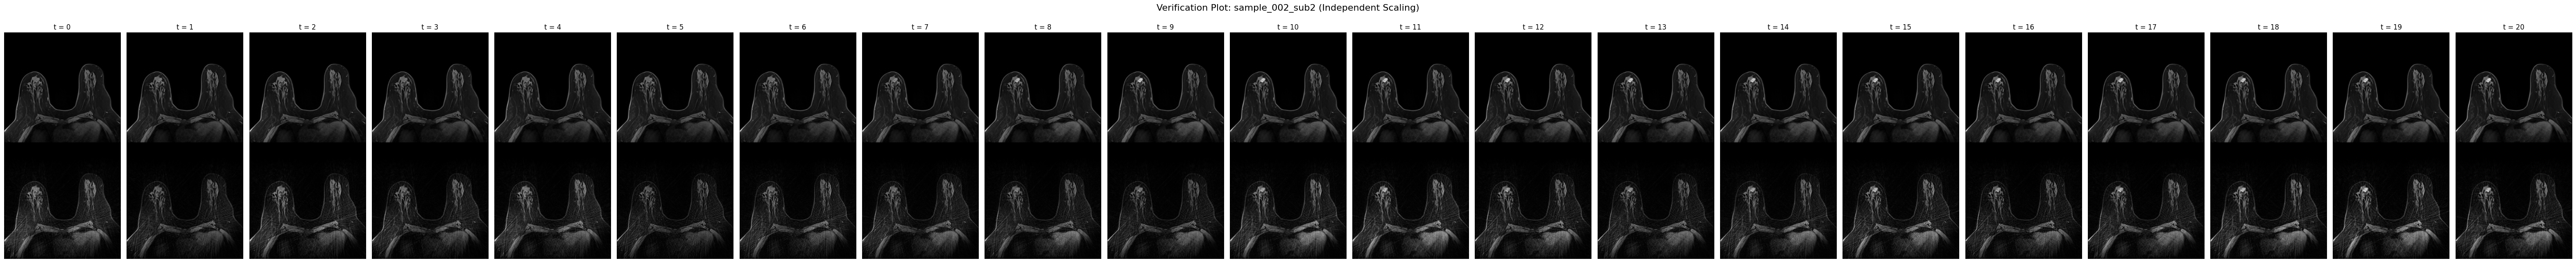

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# --- 1. CONFIGURATION: SET YOUR PATHS HERE ---
# ===================================================================

# Set the main directory where all your 'sample_XXX_sub_Y' folders are.
BASE_OUTPUT_DIRECTORY = '/ess/scratch/scratch1/rachelgordon/simulated_dataset/'

# --- Set which sample you want to load ---
# You need both the sample number and the original patient ID.
# For example, to load 'sample_001_sub_1':
SAMPLE_NUMBER = 2
PATIENT_ID = 'sub2'

# Set the number of time frames in your simulation.
NUM_TIME_FRAMES = 21

# ===================================================================
# --- 2. BUILD FILE PATHS ---
# ===================================================================

sample_dir = os.path.join(BASE_OUTPUT_DIRECTORY, f"sample_{SAMPLE_NUMBER:03d}_{PATIENT_ID}")

# Check if the main sample directory exists
if not os.path.isdir(sample_dir):
    raise FileNotFoundError(f"The specified sample directory does not exist: {sample_dir}\nPlease check your SAMPLE_NUMBER and PATIENT_ID.")

print(f"Loading data from: {sample_dir}\n")

# ===================================================================
# --- 3. LOAD ALL DATA FROM .NPY FILES ---
# ===================================================================

try:
    # Load the primary image stacks
    dro_image_stack = np.load(os.path.join(sample_dir, 'dro_ground_truth.npy'))
    recon_image_stack = np.load(os.path.join(sample_dir, 'reconstructed_image.npy'))
    
    # You can also load the other data if you need it for analysis
    csmaps = np.load(os.path.join(sample_dir, 'csmaps.npy'))
    # kspace = np.load(os.path.join(sample_dir, 'simulated_kspace.npy')) # Uncomment if needed
    
    print("Successfully loaded data from .npy files:")
    print(f"  - DRO Ground Truth Shape:  {dro_image_stack.shape}")
    print(f"  - Reconstructed Image Shape: {recon_image_stack.shape}")
    print(f"  - Coil Sensitivity Maps Shape: {csmaps.shape}")

except FileNotFoundError as e:
    print(f"Fatal Error: Could not load required .npy file.")
    print(e)
    # Stop execution if files are missing
    raise
# ===================================================================
# --- 4. VISUALIZE THE LOADED DATA (CORRECTED) ---
# ===================================================================

# Prepare the plot
fig, axes = plt.subplots(2, NUM_TIME_FRAMES, figsize=(NUM_TIME_FRAMES * 3, 6.5))
fig.suptitle(f"Verification Plot: {os.path.basename(sample_dir)} (Independent Scaling)", fontsize=16)

# NO LONGER NEED A SINGLE max_val. We let each plot scale itself.

for t in range(NUM_TIME_FRAMES):
    # Plot Ground Truth DRO (Top Row)
    # By not specifying vmin/vmax, matplotlib auto-scales it.
    axes[0, t].imshow(np.abs(dro_image_stack[:, :, t]), cmap='gray')
    axes[0, t].set_title(f"t = {t}")
    axes[0, t].axis('off')

    # Plot Reconstructed Image (Bottom Row)
    # This will also be auto-scaled to its own min/max values.
    axes[1, t].imshow(np.abs(recon_image_stack[:, :, t]), cmap='gray')
    axes[1, t].axis('off')

# Add row labels
axes[0, 0].set_ylabel("Ground Truth DRO", fontsize=12, labelpad=20)
axes[1, 0].set_ylabel("Reconstruction", fontsize=12, labelpad=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Generating high-quality plot for DRO images...
Using consistent scaling for all images: vmin=0.00, vmax=50.45


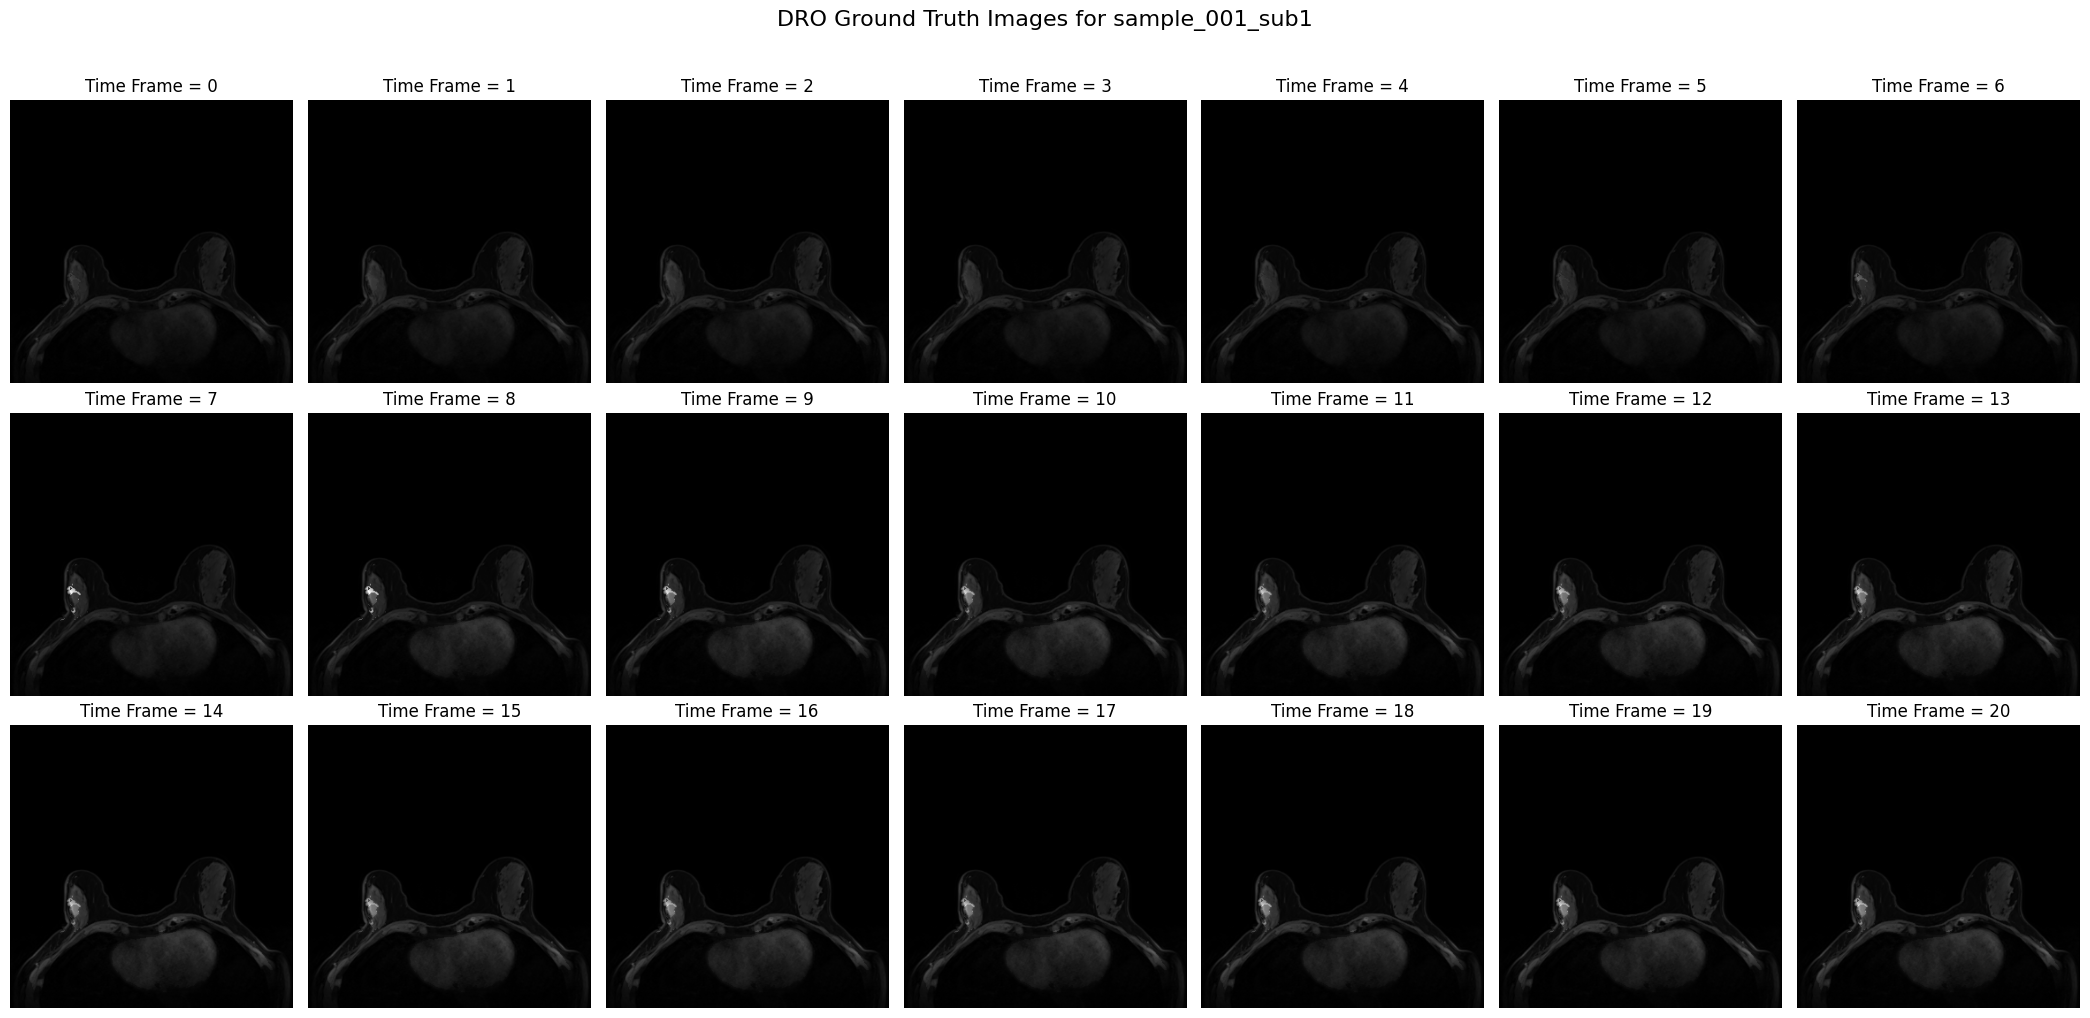

In [7]:


# ===================================================================
# --- 4. VISUALIZE THE DRO IMAGES WITH HIGH QUALITY ---
# ===================================================================

print("\nGenerating high-quality plot for DRO images...")

# --- Configuration for the Plot Layout ---
# You can change this to control how many images appear per row.
# For 21 frames, 7 columns is a good choice.
COLS_PER_ROW = 7
NUM_TIME_FRAMES = 21
# Calculate the number of rows needed
num_rows = (NUM_TIME_FRAMES + COLS_PER_ROW - 1) // COLS_PER_ROW # This is a ceiling division

# --- Create the figure and axes ---
# We make the figure taller to accommodate multiple rows.
fig, axes = plt.subplots(num_rows, COLS_PER_ROW, figsize=(COLS_PER_ROW * 3, num_rows * 3.5))
fig.suptitle(f"DRO Ground Truth Images for {os.path.basename(sample_dir)}", fontsize=16)

# --- IMPORTANT: Calculate a consistent brightness/contrast scale ---
# We find the min and max signal intensity across ALL time frames.
# Using a consistent scale is essential to visually see the enhancement.
vmin = np.min(np.abs(dro_image_stack))
vmax = np.max(np.abs(dro_image_stack))
print(f"Using consistent scaling for all images: vmin={vmin:.2f}, vmax={vmax:.2f}")


# Flatten the axes array to make it easy to iterate through
# This handles any number of rows/columns automatically.
axes_flat = axes.flatten()

for t in range(NUM_TIME_FRAMES):
    ax = axes_flat[t]
    
    # Display the ground truth DRO for the current time frame
    # We use the calculated vmin and vmax for consistent scaling.
    img = ax.imshow(np.abs(dro_image_stack[:, :, t]), cmap='gray', vmin=vmin, vmax=vmax)
    
    # Add a title to each subplot indicating the time frame
    ax.set_title(f"Time Frame = {t}")
    
    # Turn off the pixel coordinate axes for a cleaner look
    ax.axis('off')

# --- Clean up any unused subplots ---
# If you have 21 frames and a 3x7 grid, there are no unused plots.
# If you had 20 frames, this would turn off the 21st plot.
for i in range(NUM_TIME_FRAMES, len(axes_flat)):
    axes_flat[i].axis('off')

# --- Adjust layout and show the plot ---
# `tight_layout` cleans up spacing between plots.
# The `rect` argument prevents the suptitle from overlapping the subplots.
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Plotting 16 coil sensitivity maps...


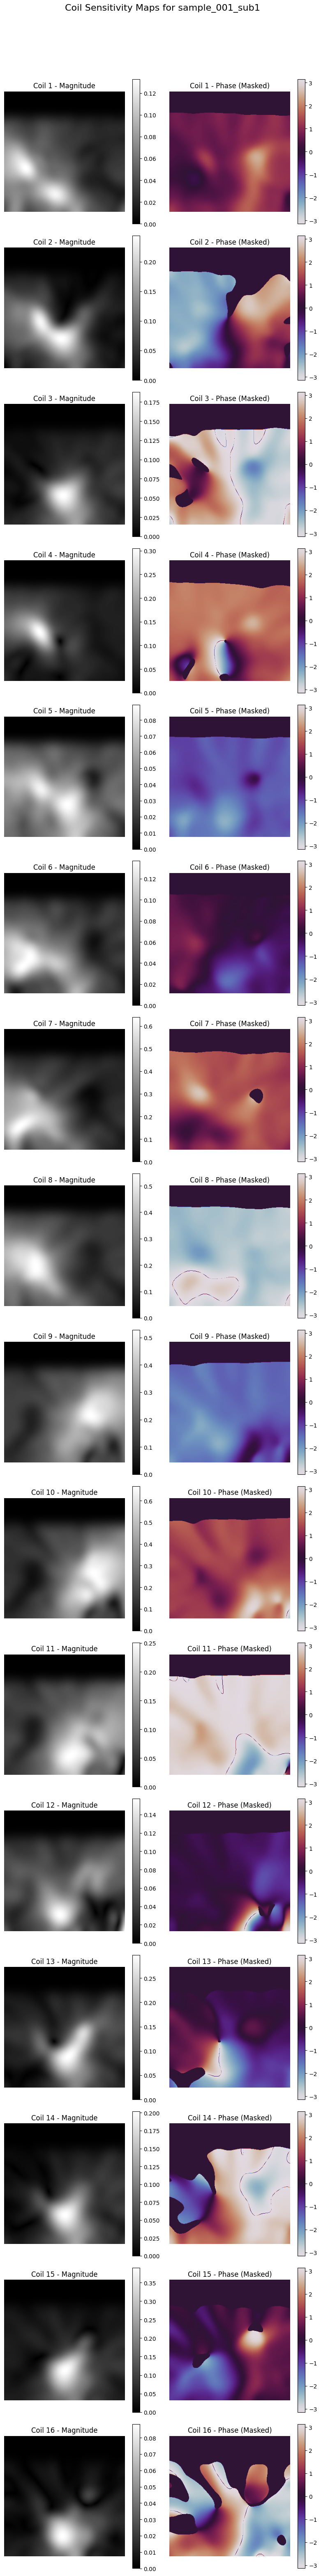

In [20]:
# ===================================================================
# --- 5. VISUALIZE SENSITIVITY MAPS ---
# ===================================================================

# Check if the csmaps were loaded successfully
if csmaps is not None:
    # Get the number of coils from the shape of the csmaps array
    num_coils = csmaps.shape[2]
    
    # Create a new figure for the sensitivity maps
    # We will have one row per coil, and two columns (Magnitude, Phase)
    fig_smaps, axes_smaps = plt.subplots(num_coils, 2, figsize=(8, 4 * num_coils), squeeze=False)
    fig_smaps.suptitle(f"Coil Sensitivity Maps for {os.path.basename(sample_dir)}", fontsize=16)

    print(f"\nPlotting {num_coils} coil sensitivity maps...")

    for i in range(num_coils):
        # Isolate the map for the current coil
        coil_map = csmaps[:, :, i]

        # --- 1. Plot the MAGNITUDE ---
        magnitude = np.abs(coil_map)
        ax_mag = axes_smaps[i, 0]
        im_mag = ax_mag.imshow(magnitude, cmap='gray')
        ax_mag.set_title(f"Coil {i+1} - Magnitude")
        ax_mag.axis('off')
        fig_smaps.colorbar(im_mag, ax=ax_mag) # Add a colorbar for each magnitude plot

        # --- 2. Plot the PHASE (with masking) ---
        phase = np.angle(coil_map)
        
        # Create a mask to hide phase in low-signal areas, making it cleaner
        magnitude_mask = magnitude > (0.05 * magnitude.max())
        phase_masked = np.zeros_like(phase)
        phase_masked[magnitude_mask] = phase[magnitude_mask]
        
        ax_phase = axes_smaps[i, 1]
        # Use a circular colormap like 'twilight' for phase data
        im_phase = ax_phase.imshow(phase_masked, cmap='twilight', vmin=-np.pi, vmax=np.pi)
        ax_phase.set_title(f"Coil {i+1} - Phase (Masked)")
        ax_phase.axis('off')
        fig_smaps.colorbar(im_phase, ax=ax_phase) # Add a colorbar for each phase plot

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("\nSkipping sensitivity map plot because 'csmaps' data was not loaded.")


Plotting 16 coil sensitivity maps in a 4x4 grid...


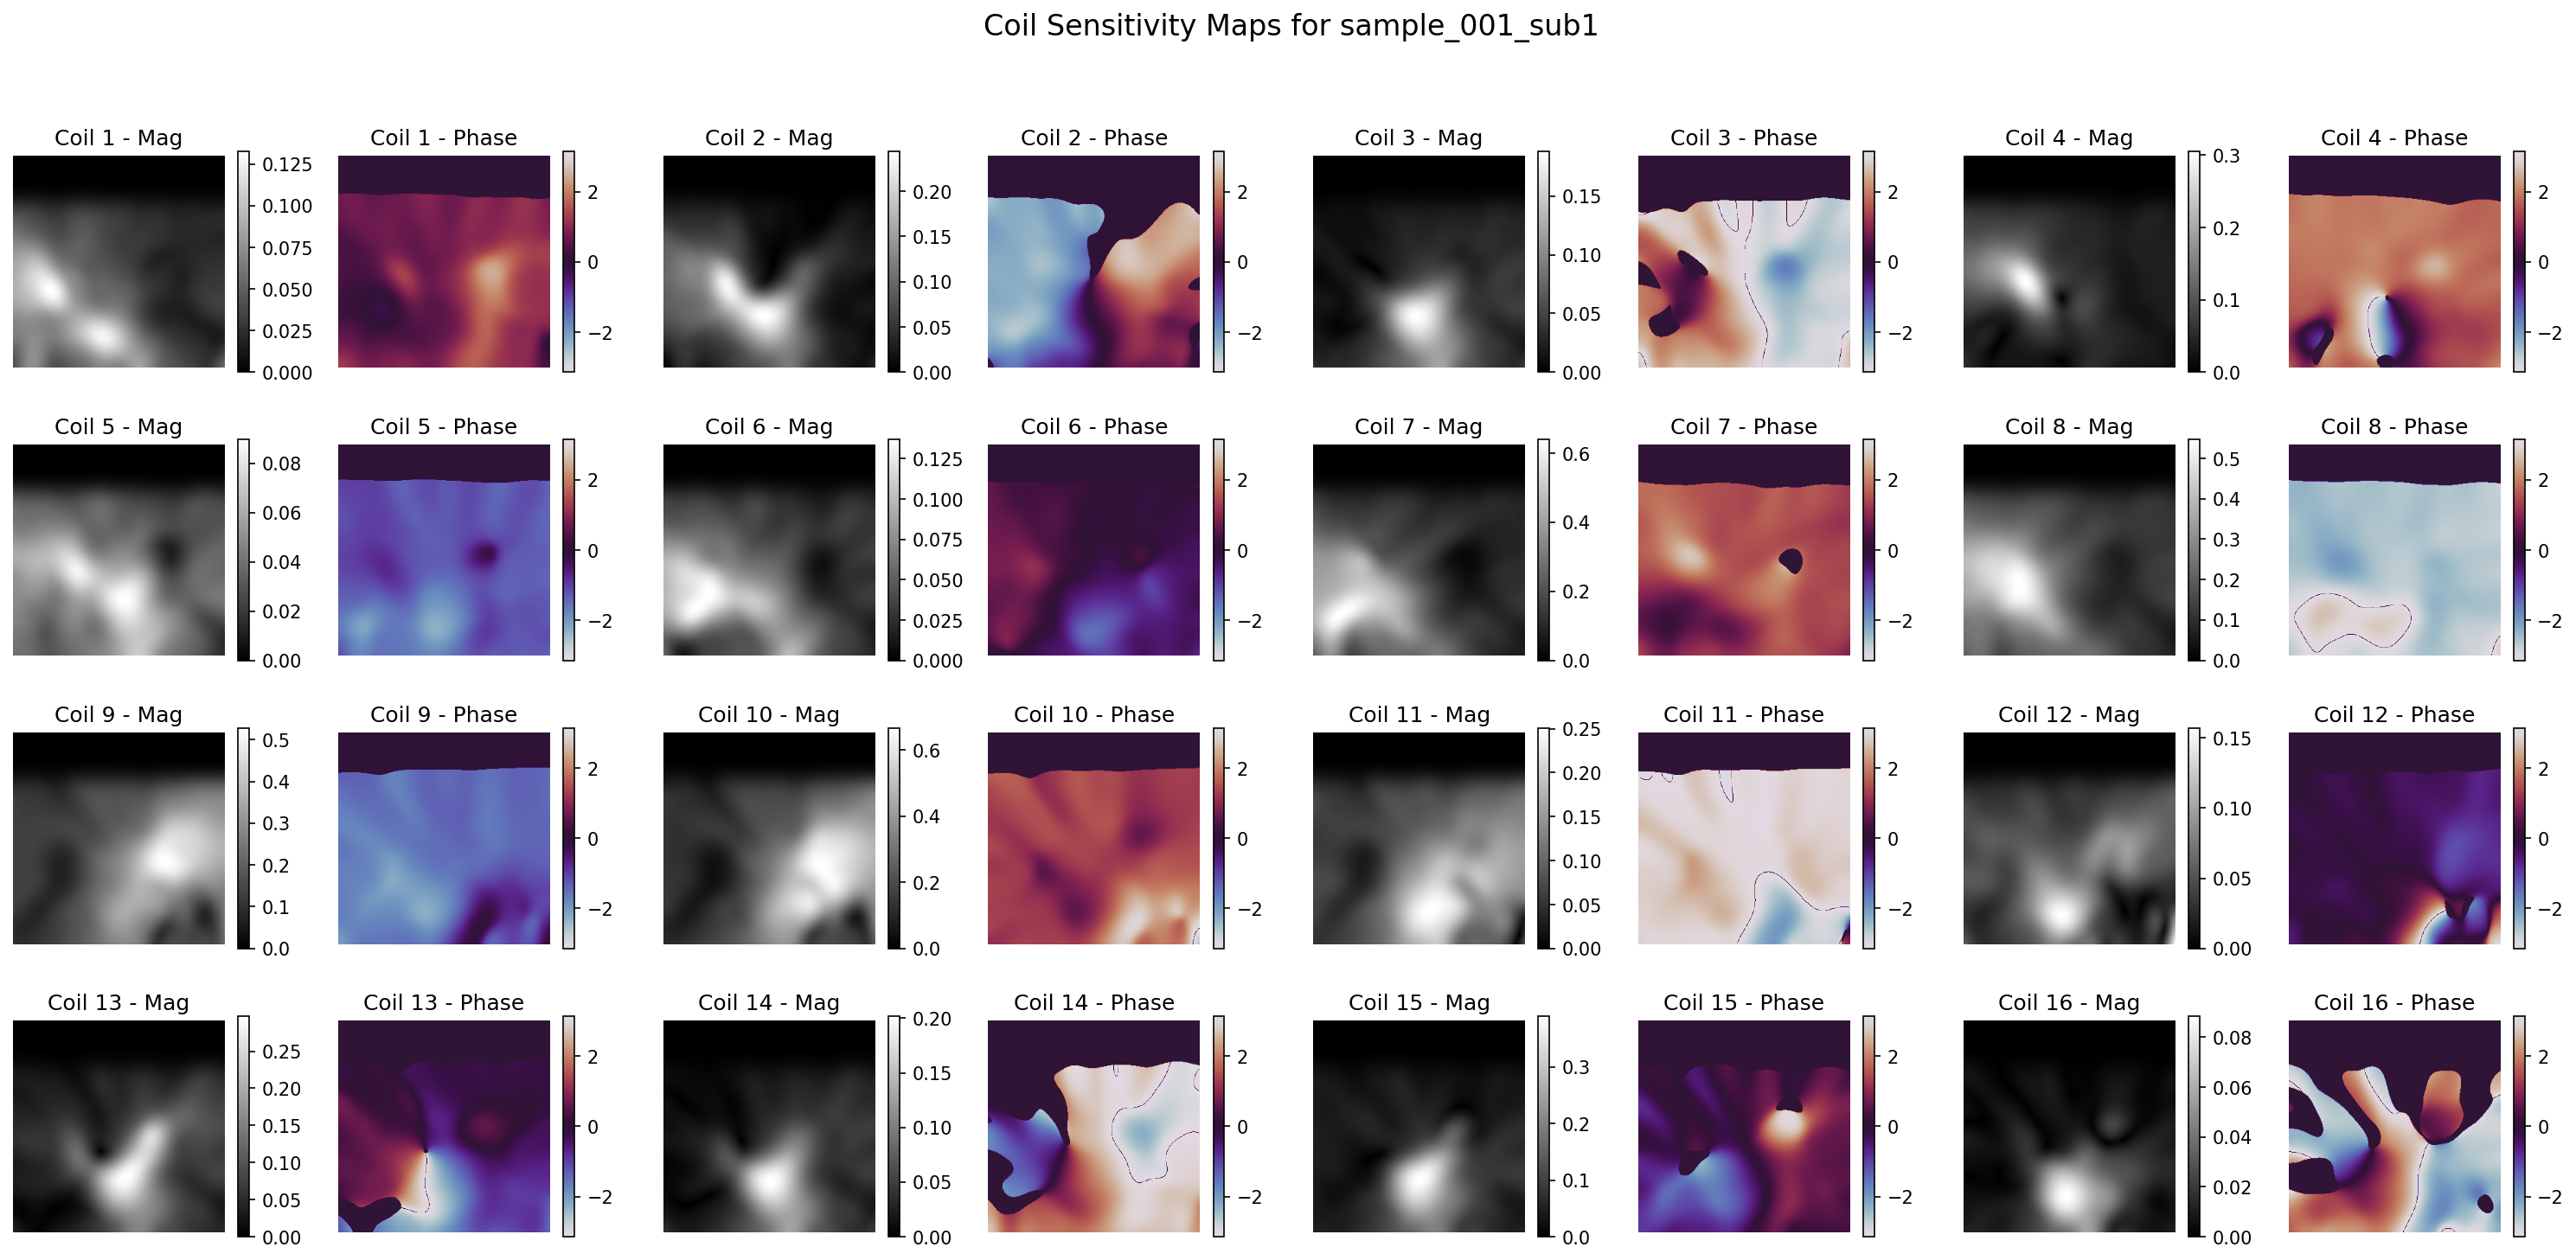

In [23]:
# ===================================================================
# --- 5. VISUALIZE SENSITIVITY MAPS (IMPROVED GRID LAYOUT) ---
# ===================================================================

# Check if the csmaps were loaded successfully
if csmaps is not None:
    # Get the number of coils from the shape of the csmaps array
    num_coils = csmaps.shape[2]
    
    # --- Define the grid layout ---
    nrows = 4
    # Calculate how many columns of coils we need
    ncols_coils = (num_coils + nrows - 1) // nrows # Ceiling division
    # Total columns for plots = coil columns * 2 (for Mag + Phase)
    ncols_plots = ncols_coils * 2
    
    # --- Create a new figure with a grid layout and higher resolution ---
    fig_smaps, axes_smaps = plt.subplots(
        nrows, 
        ncols_plots, 
        figsize=(ncols_plots * 2.5, nrows * 2.5), # Adjust size for grid
        dpi=150, # <--- HIGHER RESOLUTION FOR BETTER QUALITY
        squeeze=False
    )
    fig_smaps.suptitle(f"Coil Sensitivity Maps for {os.path.basename(sample_dir)}", fontsize=16)

    print(f"\nPlotting {num_coils} coil sensitivity maps in a {nrows}x{ncols_coils} grid...")

    for i in range(num_coils):
        # --- Calculate the row and column index for the current coil ---
        row_idx = i // ncols_coils
        col_idx_base = (i % ncols_coils) * 2 # Base column for magnitude

        # Isolate the map and axes for the current coil
        coil_map = csmaps[:, :, i]
        ax_mag = axes_smaps[row_idx, col_idx_base]
        ax_phase = axes_smaps[row_idx, col_idx_base + 1]

        # --- 1. Plot the MAGNITUDE ---
        magnitude = np.abs(coil_map)
        im_mag = ax_mag.imshow(magnitude, cmap='gray')
        ax_mag.set_title(f"Coil {i+1} - Mag") # Shorter title for grid
        ax_mag.axis('off')
        fig_smaps.colorbar(im_mag, ax=ax_mag, shrink=0.8) # Shrink colorbar slightly

        # --- 2. Plot the PHASE (with masking) ---
        phase = np.angle(coil_map)
        magnitude_mask = magnitude > (0.05 * magnitude.max())
        phase_masked = np.zeros_like(phase)
        phase_masked[magnitude_mask] = phase[magnitude_mask]
        
        im_phase = ax_phase.imshow(phase_masked, cmap='twilight', vmin=-np.pi, vmax=np.pi)
        ax_phase.set_title(f"Coil {i+1} - Phase") # Shorter title for grid
        ax_phase.axis('off')
        fig_smaps.colorbar(im_phase, ax=ax_phase, shrink=0.8)

    # --- Hide any unused subplots if num_coils is not a perfect multiple ---
    for j in range(num_coils, nrows * ncols_coils):
        row_idx = j // ncols_coils
        col_idx_base = (j % ncols_coils) * 2
        axes_smaps[row_idx, col_idx_base].axis('off')
        axes_smaps[row_idx, col_idx_base + 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("\nSkipping sensitivity map plot because 'csmaps' data was not loaded.")